In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
import os
%matplotlib inline

/home/david/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def load_pickle(filename):
    with open(filename, 'rb') as f:
        arr = pickle.load(f)
    return arr

In [3]:
test = load_pickle(os.path.join('data', 'bouncing_balls_testing_data.pkl'))
test = np.repeat(np.expand_dims(test, 4), 3, axis=4)

test.shape

(1000, 20, 80, 80, 3)

In [4]:
def show_sequence(arr):
    plt.rcParams['figure.figsize'] = [15, 8]
    batch, length, width, height, depth = arr.shape
    out = np.zeros((batch*height, length*width, depth))
    for x in range(length):
        for y in range(batch):
            out[y*height:(y+1)*height,x*width:(x+1)*width,:] = arr[y,x,:,:,:]
    out[0::height,:,:] = 1.0
    out[:,0::width,:] = 1.0
    out[1::height,:,:] = 1.0
    out[:,1::width,:] = 1.0
    plt.imshow(out,cmap=matplotlib.cm.Greys_r)

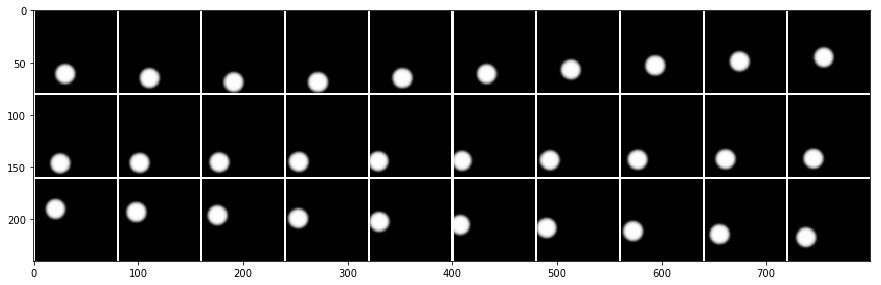

In [5]:
show_sequence(test[:3,:10,:,:,:])

In [6]:
import train_env_model as model

tf.reset_default_graph()

length, width, height, depth = (13, 80, 80, 3)
obs_ph = tf.placeholder(tf.float32, [None, length, width, height, depth])
actions_ph = tf.placeholder(tf.int32, [None, length])
is_pdt_ph = tf.placeholder(tf.bool, [None, 10])

with tf.variable_scope('env_model'):
    m = model.EnvModel(is_pdt_ph, obs_ph, actions_ph, 1, 10)
saver = tf.train.Saver()


Reg loss limit: 320.000


In [7]:
checkpoint = '/home/david/git/rl_ssms/results/20190119-222356/20190119-222356-9999'
with tf.Session() as sess:
    saver.restore(sess, checkpoint)
    
    batch_size = 16
    length = 10

    obs = test[0:10,:13,:,:,:]
    actions = np.zeros((10,13), dtype=np.float32)
    
    is_pdt = np.ones((10, length), np.bool)
    #is_pdt[:,0::8] = False
    
    feed_dict = {is_pdt_ph:is_pdt, obs_ph:obs, actions_ph:actions}
    
    obs_hat_ = sess.run(m.obs_hat, feed_dict=feed_dict)

INFO:tensorflow:Restoring parameters from /home/david/git/rl_ssms/results/20190119-222356/20190119-222356-9999


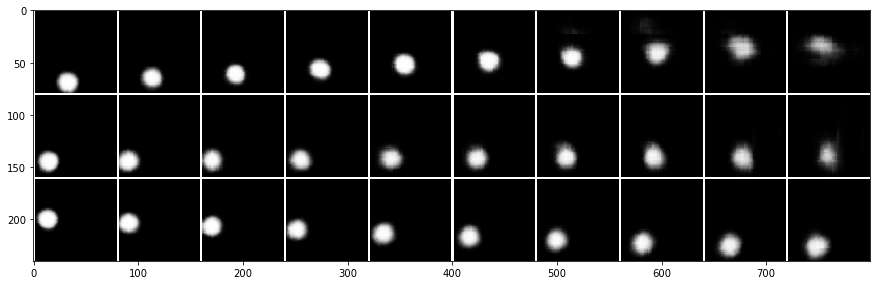

In [8]:
show_sequence(obs_hat_[:3,:10,:,:,:])

In [9]:
def load_log(log_filename):
    with open(log_filename, 'rb') as f:
        loss, rec_loss, reg_loss = pickle.load(f)
    return loss, rec_loss, reg_loss

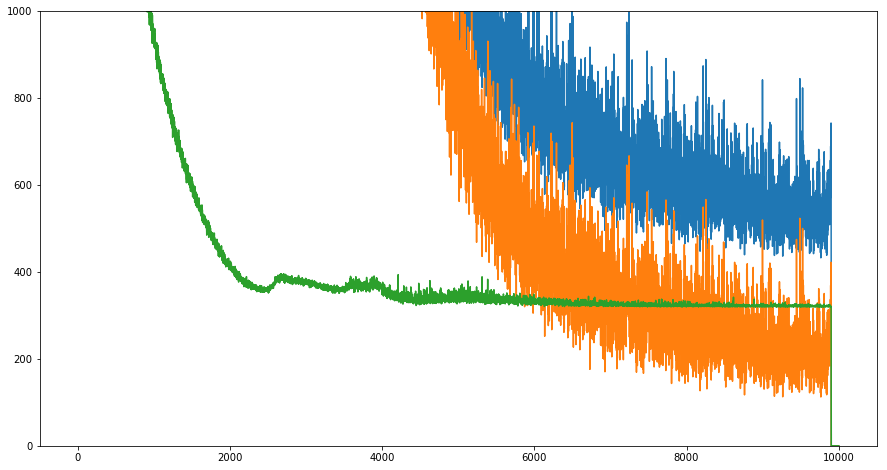

In [10]:
log_filename = '/home/david/git/rl_ssms/results/20190119-222356/log.pkl'
loss, rec_loss, reg_loss = load_log(log_filename)
plt.plot(loss)
plt.plot(rec_loss)
plt.plot(reg_loss)
_ = plt.axis((None,None,0,1000))